# Evaluation of Figure 1

In this notebook, the data for Figure 1 is prepared. Note, that due to known issues in the umap-learn package, the plots are not 100% reproducable over all machines. However the overall structure will be preserved.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import scirpy as ir
import anndata
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
from scipy.spatial.distance import pdist, squareform

C:\Users\felix.drost\Anaconda3\envs\mvTCR_repro2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../mvTCR/')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

## Celltype

In [3]:
import celltypist
from celltypist import models

In [4]:
data_full = sc.read('../mvTCR/data/10x_CD8TC/logged_10x.h5ad')
data_full.uns['log1p']['base'] = None

In [5]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 44
📂 Storing models in C:\Users\felix.drost\.celltypist\data\models
💾 Downloading model [1/44]: Immune_All_Low.pkl
💾 Downloading model [2/44]: Immune_All_High.pkl
💾 Downloading model [3/44]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [4/44]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [5/44]: Adult_Human_Skin.pkl
💾 Downloading model [6/44]: Adult_Mouse_Gut.pkl
💾 Downloading model [7/44]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [8/44]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [9/44]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [10/44]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [11/44]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [12/44]: COVID19_Immune_Landscape.pkl
💾 Downloading model [13/44]: Cells_Fetal_Lung.pkl
💾 Downloading model [14/44]: Cells_Intestinal_Tract.pkl
💾 Downloading model [15/44]: Cells_Lung_A

In [6]:
# Immune_All_High.pkl
predictions = celltypist.annotate(data_full, model='Immune_All_Low.pkl', majority_voting=True)
cd8_types = [
    'Tem/Trm cytotoxic T cells',
    'Tem/Temra cytotoxic T cells',
    'Tcm/Naive cytotoxic T cells',
    'NKT cells',
    'MAIT cells',
    'Trm cytotoxic T cells',
]
predictions.predicted_labels['predicted_labels'] = predictions.predicted_labels['predicted_labels'
                                                                               ].apply(lambda x: x 
                                                                                       if x in cd8_types 
                                                                                       else 'Unknown') 
predictions.predicted_labels['predicted_labels'].value_counts()

🔬 Input data has 178356 cells and 19707 genes
🔗 Matching reference genes in the model
🧬 5164 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


Tem/Trm cytotoxic T cells      65905
Tcm/Naive cytotoxic T cells    45612
Tem/Temra cytotoxic T cells    44157
Unknown                        16425
MAIT cells                      5184
Trm cytotoxic T cells            852
NKT cells                        221
Name: predicted_labels, dtype: int64

## Load model

In [7]:
def load_model(adata, model, donor='None'):
    #path_model = f'saved_models/journal/10x/full/donor_{donor}/{model}_'
    path_model = f'saved_models/journal_2/10x/full/10x_{donor}_full_{model}.pt'
    #path_model += f'donor_{donor}_full.pt'
    model = utils.load_model(adata, path_model)
    adata.obs['set'] = 'train'
    return model
    

In [8]:
binder_2_donor = {
    'donor_1': const.donor_1_high_count_antigens,
    'donor_2': const.donor_2_high_count_antigens,
    'donor_3': const.donor_3_high_count_antigens,
    'donor_4': const.donor_4_high_count_antigens,
    'full': const.HIGH_COUNT_ANTIGENS,
    'None': const.HIGH_COUNT_ANTIGENS,
}

In [9]:
from sklearn.preprocessing import OneHotEncoder
def load_10x_data(donor='None'):
    adata = utils.load_data('10x')
    adata = adata[adata.obs['binding_name'].isin(const.HIGH_COUNT_ANTIGENS)]
    if donor != 'None':
        adata = adata[adata.obs['donor']==donor]
    enc = OneHotEncoder(sparse=False)
    enc.fit(adata.obs['donor'].to_numpy().reshape(-1, 1))
    adata.obsm['donor'] = enc.transform(adata.obs['donor'].to_numpy().reshape(-1, 1))
    return adata

In [10]:
data = load_10x_data()

In [11]:
data.obs.groupby('donor')['binding_name'].value_counts(normalize=True)

donor    binding_name                           
donor_1  A0301_KLGGALQAK_IE-1_CMV_binder            0.287789
         A1101_IVTDFSVIK_EBNA-3B_EBV_binder         0.280112
         A0201_GILGFVFTL_Flu-MP_Influenza_binder    0.203133
         A1101_AVFDRKSDAK_EBNA-3B_EBV_binder        0.191825
         A0201_ELAGIGILTV_MART-1_Cancer_binder      0.017844
         A0301_RLRAEAQVK_EMNA-3A_EBV_binder         0.010478
         B0801_RAKFKQLL_BZLF1_EBV_binder            0.006847
         A0201_GLCTLVAML_BMLF1_EBV_binder           0.001971
donor_2  B0801_RAKFKQLL_BZLF1_EBV_binder            0.603953
         A0201_GILGFVFTL_Flu-MP_Influenza_binder    0.199183
         A0301_KLGGALQAK_IE-1_CMV_binder            0.132016
         A0201_GLCTLVAML_BMLF1_EBV_binder           0.045048
         A1101_AVFDRKSDAK_EBNA-3B_EBV_binder        0.013323
         A1101_IVTDFSVIK_EBNA-3B_EBV_binder         0.002944
         A0301_RLRAEAQVK_EMNA-3A_EBV_binder         0.002503
         A0201_ELAGIGILTV_MART-1_Can

## Loading

In [12]:
def add_clonotypes(latent):
    expanded_clonotypes = latent.obs['clonotype'].value_counts()
    expanded_clonotypes = expanded_clonotypes[:9].index
    
    latent.obs['large_clonotype'] = [el if el in expanded_clonotypes
                                  else 'Other' 
                                  for el in latent.obs['clonotype']]
    latent.obs['large_clonotype'] = latent.obs['large_clonotype'].astype(str)

In [13]:
for donor in tqdm(['donor_1', 'donor_2', 'donor_3', 'donor_4', 'None']):
    data = load_10x_data(donor)
    data.obs['celltype'] = predictions.predicted_labels['predicted_labels']
    for model_name in ['moe', 'rna', 'tcr', 'concat', 'poe']:
        model = load_model(data, model_name, donor)
        latent = model.get_latent(data, metadata=['donor', 'binding_name', 'clonotype'], return_mean=True)
        sc.pp.neighbors(latent, use_rep='X')
        sc.tl.umap(latent)
        
        add_clonotypes(latent)
        latent.obs['celltype'] = predictions.predicted_labels['predicted_labels']
        
        if (donor == 'None') and (model_name == 'moe'):
            model.get_modality_contribution(data)
            latent.obs['Contribution TCR'] = data.obs['contribution_tcr-rna']
        
        sc.write(adata=latent, filename=f'../results/fig1_{model_name}_{donor}_full.h5ad')     

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
 20%|████████████████▌                                                                  | 1/5 [02:00<08:02, 120.50s/it]... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'large_clonotype' as categorical
... storing 'celltype' as categorical
... storing 'la

## Leiden annotation based on best NMI value

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:54<00:00,  9.54s/it]


moe - NMI: 0.5351123823882216


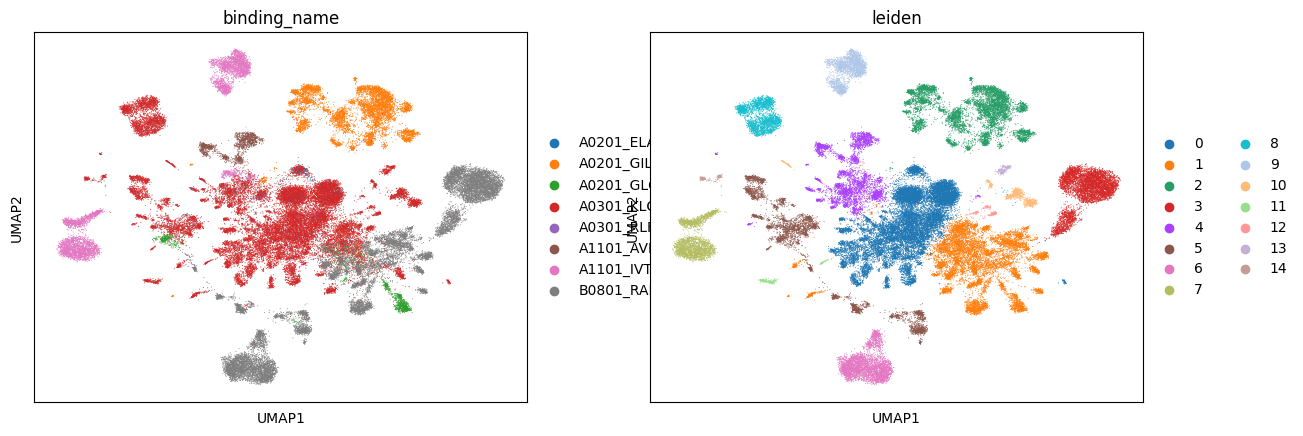

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:08<00:00, 10.69s/it]


rna - NMI: 0.45578279489556733


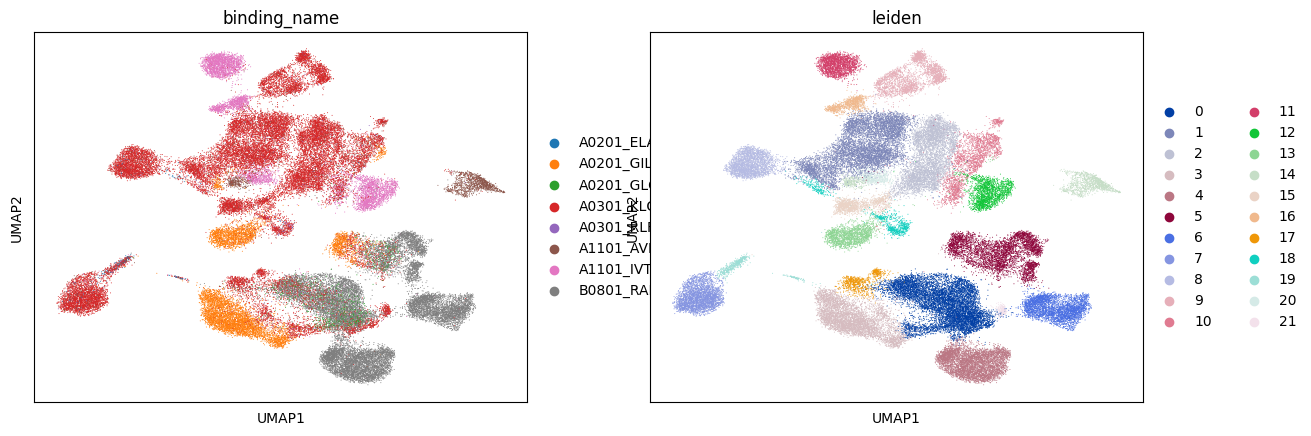

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:22<00:00,  6.84s/it]


tcr - NMI: 0.40779197984136895


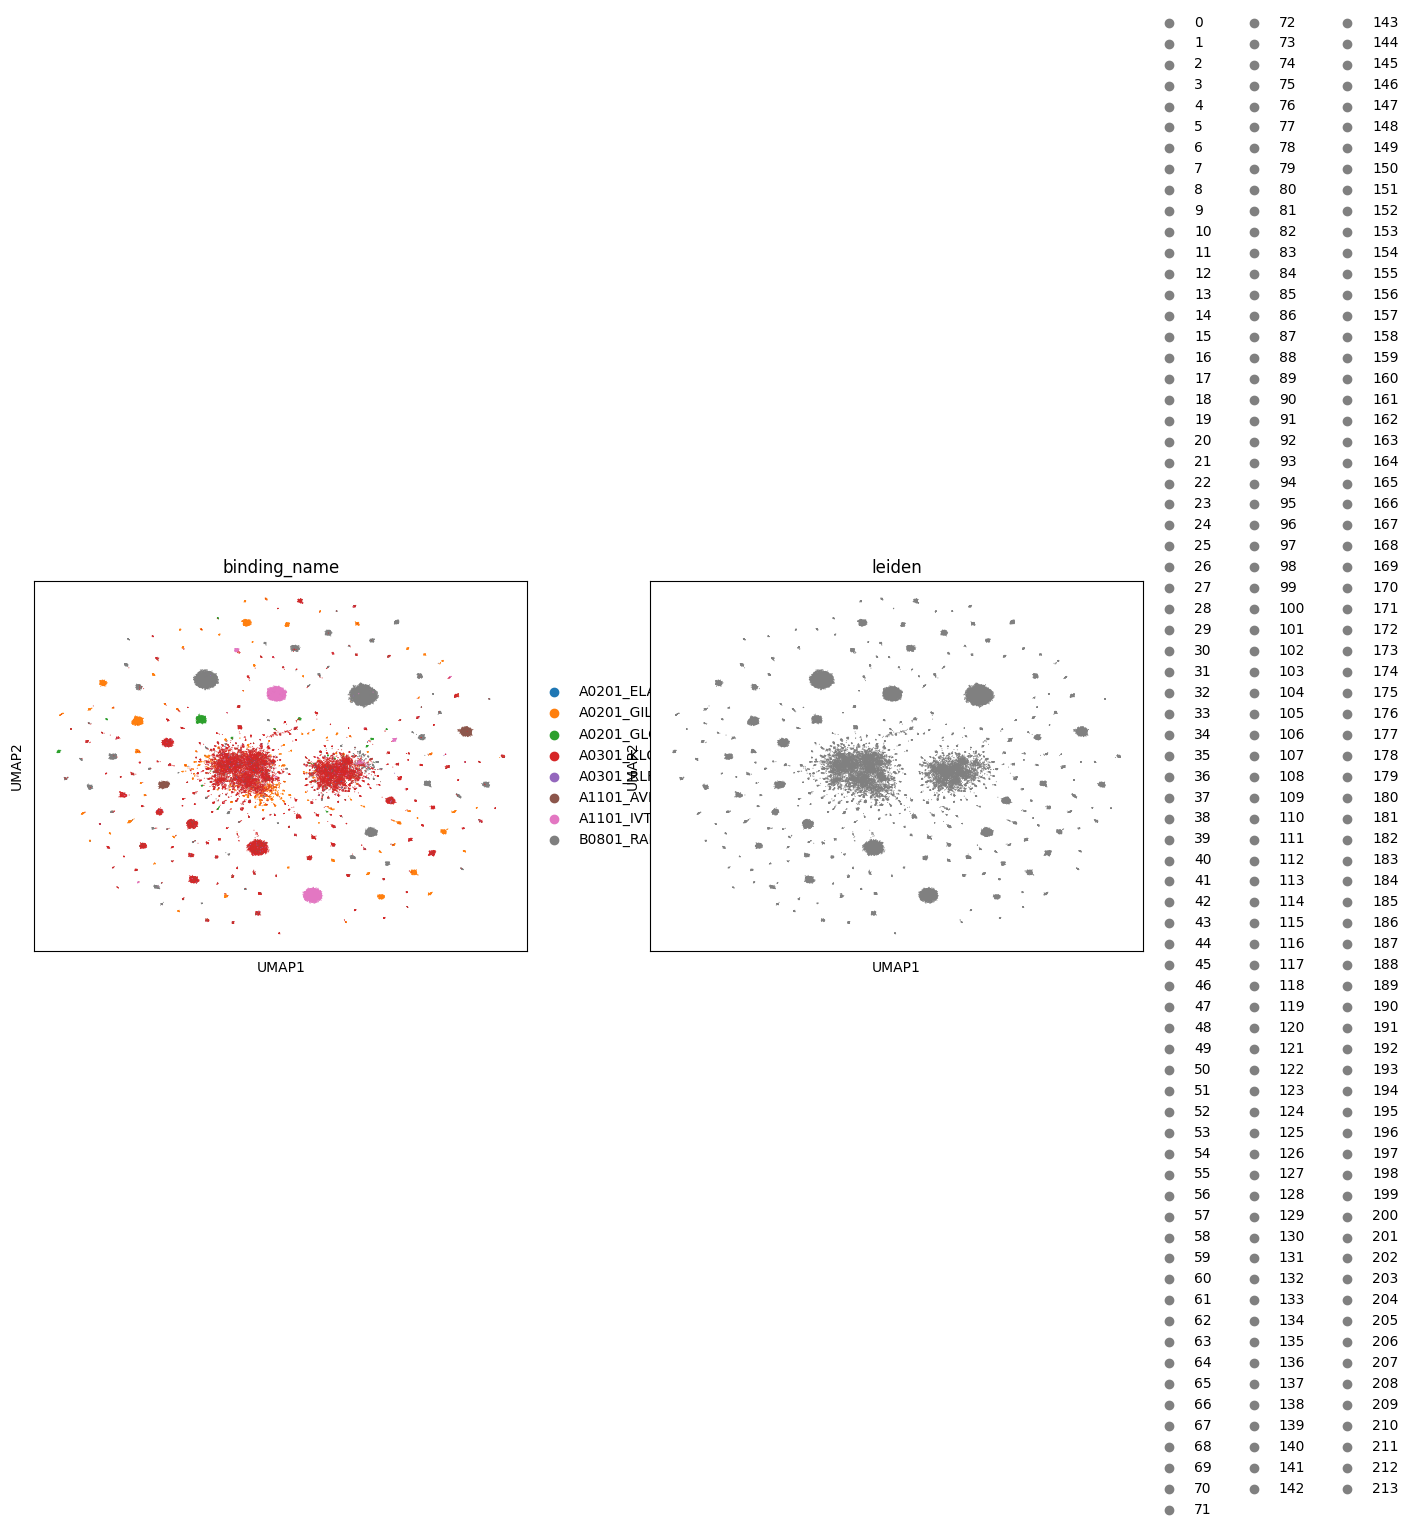

In [14]:
from sklearn.metrics import normalized_mutual_info_score

def annotate_best_leiden(model, col='binding_name', safe=True):
    if type(model) == str:
        latent = sc.read(f'../results/fig1_{model}_None_full.h5ad')
        sc.pp.neighbors(latent)
    else:
        latent = model
    best_nmi = -99
    best_res = -99
    for resolution in tqdm([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        sc.tl.leiden(latent, resolution=resolution)
        cluster_result = normalized_mutual_info_score(latent.obs[col], 
                                                      latent.obs['leiden'], average_method='arithmetic')
        if best_nmi < cluster_result:
            best_nmi = cluster_result
            best_res = resolution

    print(f'{model} - NMI: {best_nmi}')
    sc.tl.leiden(latent, resolution=best_res)
    if safe:
        sc.pl.umap(latent, color=[col, 'leiden'])
        sc.write(adata=latent, filename=f'../results/fig1_{model}_None_full.h5ad')
        return latent
    else:
        return best_nmi

latent_moe = annotate_best_leiden('moe')
latent_rna = annotate_best_leiden('rna')
latent_tcr = annotate_best_leiden('tcr')

## TcrDist

In [15]:
data = load_10x_data('None')
latent_moe = sc.read(f'../results/fig1_moe_None_full.h5ad')

In [16]:
from tcrdist.repertoire import TCRrep
from tcrdist.tree import TCRtree
from tqdm import tqdm

In [17]:
latent_moe.uns['pw_tcrdist'] = {}
for epitope in tqdm(data.obs['binding_name'].unique()):
    adata_tmp = data[data.obs['binding_name']==epitope]

    df_clonotype = adata_tmp.obs[['IR_VJ_1_v_call', 'IR_VJ_1_junction_aa', 
                         'IR_VDJ_1_v_call', 'IR_VDJ_1_junction_aa', 'clonotype']]
    df_clonotype = df_clonotype.drop_duplicates(['IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa'])
    df_clonotype = df_clonotype.reset_index(drop=True)
    df_clonotype = df_clonotype.rename(columns={
        'IR_VJ_1_v_call': 'v_a_gene',
        'IR_VJ_1_junction_aa': 'cdr3_a_aa',

        'IR_VDJ_1_v_call': 'v_b_gene',
        'IR_VDJ_1_junction_aa':  'cdr3_b_aa'
    })

    for col in df_clonotype.columns:
        dtype = str
        df_clonotype[col] = df_clonotype[col].astype(dtype)

    df_clonotype['v_a_gene'] = df_clonotype['v_a_gene'] + '*01'
    df_clonotype['v_b_gene'] = df_clonotype['v_b_gene'] + '*01'

    tr = TCRrep(cell_df=df_clonotype, organism='human', chains=['alpha','beta'])
    dists = tr.pw_alpha + tr.pw_beta

    dists = np.triu(dists, k=1) # mask lower triangular + diagonal entries
    dists[dists==0] = -99

    columns = tr.clone_df['clonotype']
    #dists = pd.DataFrame(dists, columns=columns, index=columns)
    dists = dists[dists!=-99]
    latent_moe.uns['pw_tcrdist'][epitope] = dists.copy()
    
sc.write(adata=latent_moe, filename=f'../results/fig1_moe_None_full.h5ad')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:42<00:00,  5.34s/it]


In [18]:
latent_moe = sc.read(f'../results/fig1_moe_None_full.h5ad')
latent_rna = sc.read(f'../results/fig1_rna_None_full.h5ad')
latent_tcr = sc.read(f'../results/fig1_tcr_None_full.h5ad')

## TCR Scores

In [19]:
# marker scores => cd8 cytotocix score
tcell_markers = pd.read_excel('data/41467_2019_12464_MOESM7_ESM.xlsx', skiprows=1)
for k, v in tcell_markers.items():
    score_name = k.lower() + "_score"
    data.obs[score_name] = np.mean(
        (
            data[:, [x for x in v if x in data.var_names]].X - 
            data[:, [x for x in v if x in data.var_names]].X.mean(axis=0)
        ) / data[:, [x for x in v if x in data.var_names]].X.todense().std(axis=0),
        axis=1)
    latent_moe.obs[score_name] = data.obs[score_name]
    latent_rna.obs[score_name] = data.obs[score_name]
    latent_tcr.obs[score_name] = data.obs[score_name]

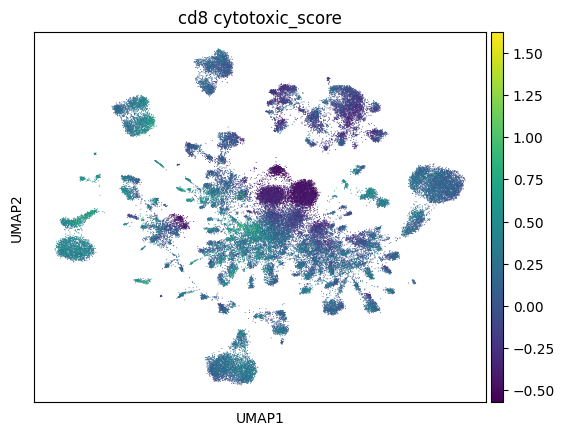

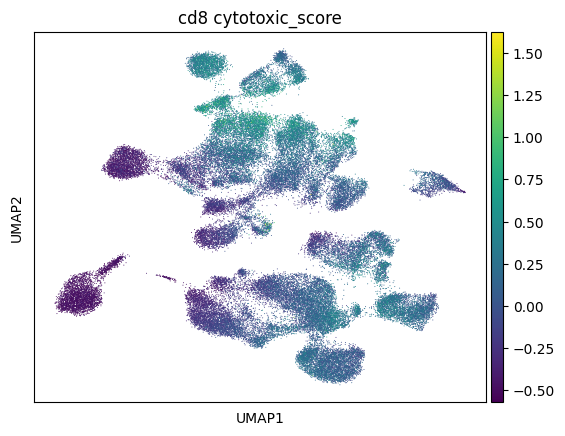

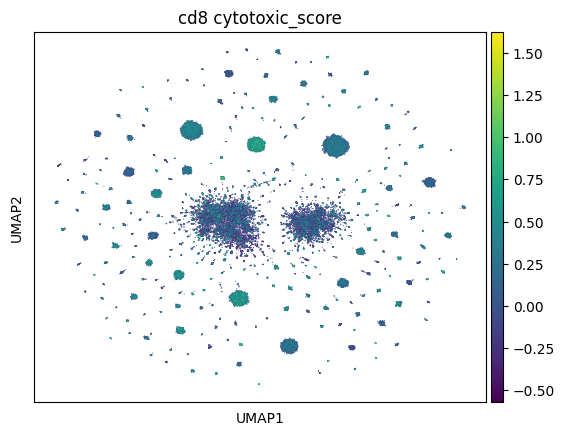

In [20]:
for latent in [latent_moe, latent_rna, latent_tcr]:
    sc.pl.umap(latent, color='cd8 cytotoxic_score')

## RNA conservation

In [21]:
# RNA Leiden cluster conservation
latent_moe.obs['leiden_rna'] = latent_rna.obs['leiden']
latent_tcr.obs['leiden_rna'] = latent_rna.obs['leiden']

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:48<00:00,  9.04s/it]


moe - NMI: 0.18444177419644775


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:00<00:00, 10.00s/it]


rna - NMI: 0.2562511223085734


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:17<00:00,  6.50s/it]


tcr - NMI: 0.12695165804084058


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:31<00:00,  7.59s/it]


AnnData object with n_obs × n_vars = 61237 × 40
    obs: 'batch', 'donor', 'binding_name', 'clonotype', 'large_clonotype', 'celltype', 'Contribution TCR', 'leiden', 'treg_score', 'cd4 nv/cm_score', 'cd4/cd8_score', 'ifn response_score', 'proliferation_score', 'cd8 cytotoxic_score', 'cd8 cytokine_score', 'leiden_rna'
    uns: 'binding_name_colors', 'leiden', 'leiden_colors', 'neighbors', 'pw_tcrdist', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances' - NMI: 0.6844033845467934


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:17<00:00,  6.49s/it]


AnnData object with n_obs × n_vars = 61237 × 40
    obs: 'batch', 'donor', 'binding_name', 'clonotype', 'large_clonotype', 'celltype', 'leiden', 'treg_score', 'cd4 nv/cm_score', 'cd4/cd8_score', 'ifn response_score', 'proliferation_score', 'cd8 cytotoxic_score', 'cd8 cytokine_score', 'leiden_rna'
    uns: 'binding_name_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'connectivities', 'distances' - NMI: 0.48657395188666436


<AxesSubplot: xlabel='metric', ylabel='score'>

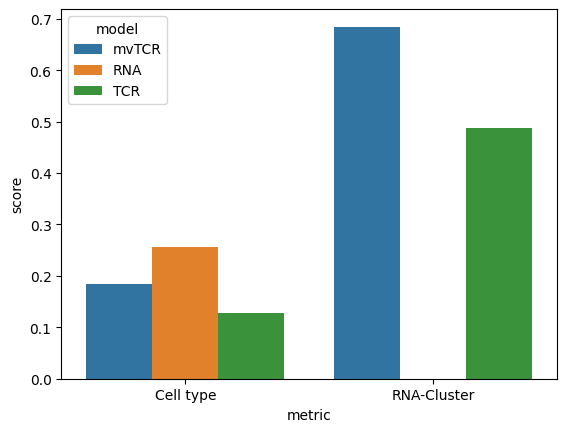

In [22]:
models = []
metrics = []
scores = []

for name in ['moe', 'rna', 'tcr']:
    models.append(name)
    metrics.append('Cell type')
    score = annotate_best_leiden(name, 'celltype', False)
    scores.append(score)

for name, latent in [('mvTCR', latent_moe), ('TCR', latent_tcr)]:
    models.append(name)
    metrics.append('RNA-Cluster')
    score = annotate_best_leiden(latent.copy(), 'leiden_rna', False)
    scores.append(score)

rna_conservation = pd.DataFrame({
    'model': models,
    'metric': metrics,
    'score': scores
})
rna_conservation = rna_conservation.replace({'moe': 'mvTCR', 'tcr': 'TCR', 'rna': 'RNA'})
latent_moe.uns['rna_conservation'] = rna_conservation
sb.barplot(data=rna_conservation, y='score', x='metric', hue='model')

## CT migration

In [23]:
latent_moe.obs['leiden_rna'] = latent_rna.obs['leiden']

In [24]:
palette = {
    '164': 'tab:blue',
    '18932': 'tab:purple',
    '18875': 'tab:orange',
    '1375': 'tab:red',
    '19283': 'tab:green',
}

In [25]:
latent_gil = latent_moe[latent_moe.obs['binding_name']=='A0201_GILGFVFTL_Flu-MP_Influenza_binder']
gil_cts_large = latent_gil.obs['clonotype'].value_counts().head(6).index

latent_moe.obs['leiden2_ct'] = latent_moe.obs['clonotype'].apply(lambda x: x if x in gil_cts_large else np.nan)
latent_rna.obs['leiden2_ct'] = latent_rna.obs['clonotype'].apply(lambda x: x if x in gil_cts_large else np.nan)

... storing 'clonotype' as categorical
... storing 'clonotype' as categorical


<AxesSubplot: title={'center': 'clonotype'}, xlabel='UMAP1', ylabel='UMAP2'>

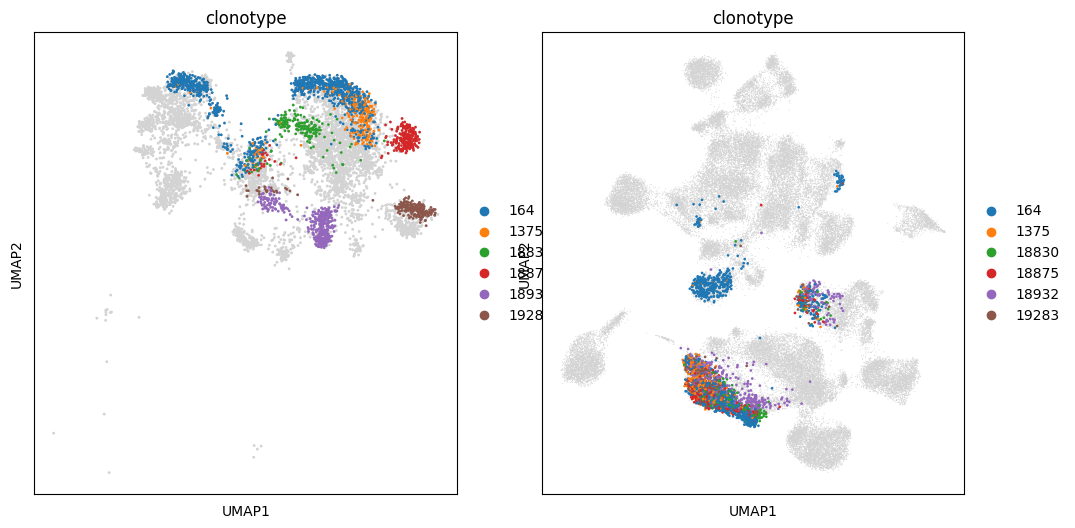

In [26]:
latent_gil = latent_moe[latent_moe.obs['binding_name']=='A0201_GILGFVFTL_Flu-MP_Influenza_binder']
gil_cts_large = latent_gil.obs['clonotype'].value_counts().head(6).index

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sc.pl.umap(latent_moe[latent_moe.obs['leiden']=='2'], show=False, ax=ax[0])
latent_tmp = latent_gil[latent_gil.obs['clonotype'].isin(gil_cts_large)]
latent_tmp.obs['clonotype'] = latent_tmp.obs['clonotype'].astype(str)
sc.pl.umap(latent_tmp[latent_tmp.obs['leiden']=='2'], color='clonotype', show=False, ax= ax[0], 
           size=15, palette=None)

sc.pl.umap(latent_rna, ax=ax[1], show=False)
latent_tmp = latent_rna[latent_rna.obs['binding_name']=='A0201_GILGFVFTL_Flu-MP_Influenza_binder']
latent_tmp = latent_tmp[latent_tmp.obs['clonotype'].isin(gil_cts_large)]
latent_tmp.obs['clonotype'] = latent_tmp.obs['clonotype'].astype(str)
sc.pl.umap(latent_tmp, color='clonotype', ax=ax[1], show=False, size=15)

## Visual RNA conservation

In [27]:
palette = sb.color_palette('muted')

<AxesSubplot: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

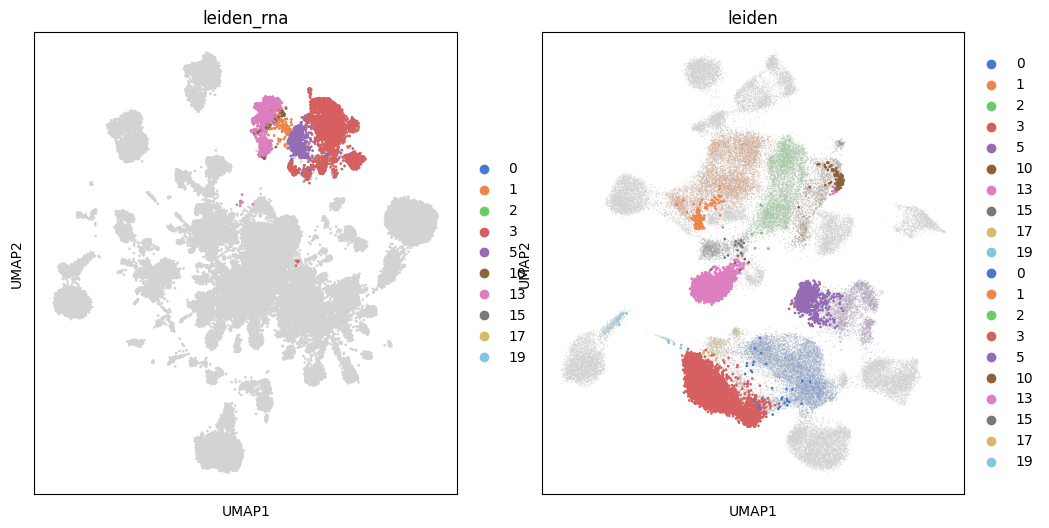

In [28]:
gil_cts_large = latent_gil.obs['clonotype'].value_counts().head(6).index

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

latent_tmp_mvtcr = latent_gil[latent_gil.obs['leiden']=='2']
sc.pl.umap(latent_moe, show=False, ax= ax[0], 
           size=15, palette=palette)

sc.pl.umap(latent_tmp_mvtcr, color='leiden_rna', show=False, ax= ax[0], 
           size=15, palette=palette)

sc.pl.umap(latent_rna, ax=ax[1], show=False)

clusters = latent_tmp_mvtcr.obs['leiden_rna'].unique()
latent_tmp = latent_rna[latent_rna.obs['leiden'].isin(clusters)]
sc.pl.umap(latent_tmp, ax=ax[1], color='leiden', 
           show=False, 
            palette=palette, alpha=0.1
          )

latent_tmp = latent_rna[latent_tmp_mvtcr.obs.index]
sc.pl.umap(latent_tmp, color='leiden', ax=ax[1], show=False, size=15,
           palette=palette)

## mvTCR- vs RNA-Distance

In [29]:
ir.tl.clonal_expansion(data, target_col='clonotype', clip_at=len(data))
data_tmp = data[data.obs['clonal_expansion'].astype(int)>=20]
sc.tl.pca(data)
np_tmp = data_tmp.obsm['X_pca']
latent_tmp = latent_moe[data.obs['clonal_expansion'].astype(int)>=20]
np_mvt = latent_tmp.X

clones = []
rna_dists = []
mvtcr_dists = []
for ct in data_tmp.obs['clonotype'].unique():
    clones.append(ct)
    mask = data_tmp.obs['clonotype'] == ct
    
    # RNA-PCA
    np_ct = np_tmp[mask]
    distances = pdist(np_ct)
    pw_dists = squareform(distances)
    upper_triangle_indices = np.triu_indices(pw_dists.shape[0], k=1)
    upper_triangle_values = pw_dists[upper_triangle_indices]
    score = np.mean(upper_triangle_values)
    rna_dists.append(score)
    
    # mvTCR
    np_ct = np_mvt[mask]
    distances = pdist(np_ct)
    pw_dists = squareform(distances)
    upper_triangle_indices = np.triu_indices(pw_dists.shape[0], k=1)
    upper_triangle_values = pw_dists[upper_triangle_indices]
    score = np.mean(upper_triangle_values)
    mvtcr_dists.append(score)

    
df_compact = pd.DataFrame({
    'CT': clones,
    'RNA-Distance': rna_dists,
    'mvTCR-Distance': mvtcr_dists
})
df_compact

,CT,RNA-Distance,mvTCR-Distance
0,10,11.796022,5.715867
1,23,8.061242,3.999743
2,26,9.760197,4.293910
3,28,10.000656,4.716693
4,30,11.669828,5.740585
...,...,...,...
242,41053,10.799750,4.603516
243,41071,10.362989,4.658885
244,41051,9.676763,4.254572
245,41081,11.268662,5.280797


In [30]:
ct_2_expansion = data.obs[['clonotype', 'clonal_expansion']].drop_duplicates()
ct_2_expansion = dict(zip(ct_2_expansion['clonotype'], ct_2_expansion['clonal_expansion']))
ct_2_nleiden = latent_moe.obs.groupby('clonotype')['leiden'].nunique()
ct_2_nleiden = dict(zip(ct_2_nleiden.index, ct_2_nleiden.values))

df_compact['expansion'] = df_compact['CT'].map(ct_2_expansion).astype(int)
df_compact['log_expansion'] = np.log(df_compact['expansion'])
df_compact['nLeiden'] = df_compact['CT'].map(ct_2_nleiden).astype(int)
df_compact

,CT,RNA-Distance,mvTCR-Distance,expansion,log_expansion,nLeiden
0,10,11.796022,5.715867,2208,7.699842,2
1,23,8.061242,3.999743,28,3.332205,1
2,26,9.760197,4.293910,192,5.257495,1
3,28,10.000656,4.716693,80,4.382027,2
4,30,11.669828,5.740585,869,6.767343,2
...,...,...,...,...,...,...
242,41053,10.799750,4.603516,2678,7.892826,2
243,41071,10.362989,4.658885,84,4.430817,2
244,41051,9.676763,4.254572,78,4.356709,1
245,41081,11.268662,5.280797,60,4.094345,1


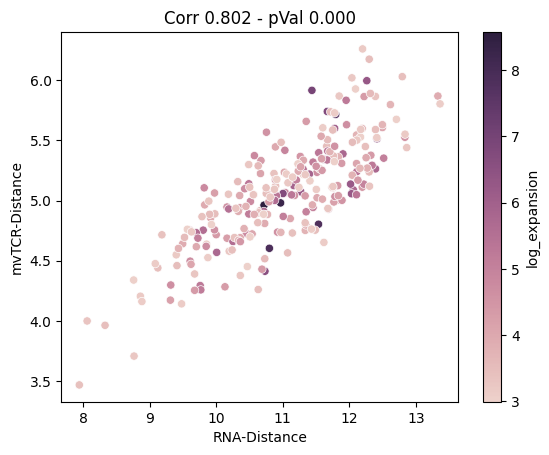

In [31]:
cmap = sb.color_palette('ch:', as_cmap= True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize())
sb.scatterplot(data=df_compact, x='RNA-Distance', y='mvTCR-Distance', hue='log_expansion',
              hue_norm= sm.norm, palette= cmap, legend= False)
cbar = plt.colorbar(sm, ax = plt.gca())
#plt.axvline(x=avg_rna_dist)
#plt.axhline(y=avg_mvtcr_dist)
cbar.set_label('log_expansion')
corr, pval = scipy.stats.pearsonr(df_compact['RNA-Distance'], df_compact['mvTCR-Distance'])
plt.title(f"Corr {corr:.3f} - pVal {pval:.3f}")

latent_moe.uns['corr_mvtcr_rna'] = df_compact

Text(0.5, 1.0, 'Corr 0.015 - pVal 0.820')

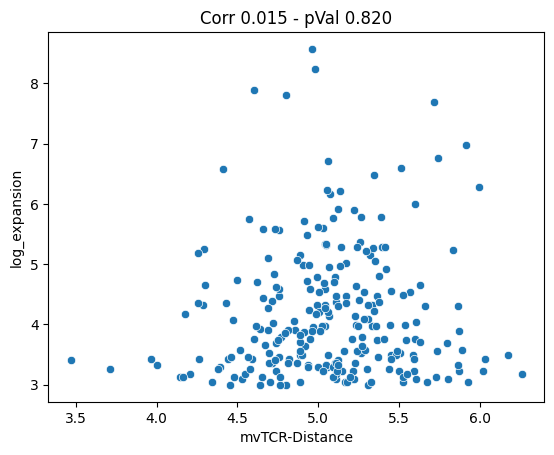

In [32]:
plot = sb.scatterplot(data=df_compact, x='mvTCR-Distance', y='log_expansion',
              hue_norm= sm.norm, palette= cmap, legend= False)
corr, pval = scipy.stats.pearsonr(df_compact['mvTCR-Distance'], df_compact['expansion'])
plt.title(f"Corr {corr:.3f} - pVal {pval:.3f}")

Text(0.5, 1.0, 'Corr 0.039 - pVal 0.545')

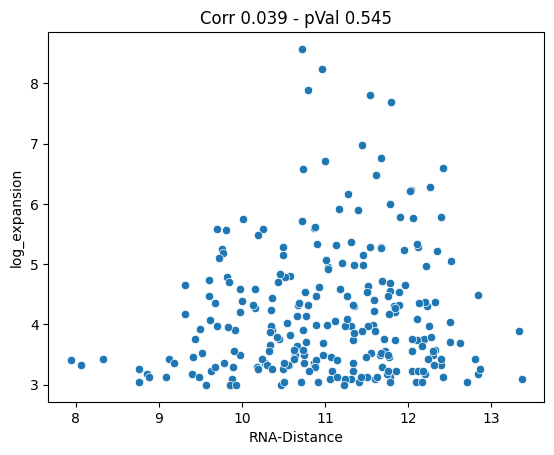

In [33]:
plot = sb.scatterplot(data=df_compact, x='RNA-Distance', y='log_expansion',
              hue_norm= sm.norm, palette= cmap, legend= False)
corr, pval = scipy.stats.pearsonr(df_compact['RNA-Distance'], df_compact['expansion'])
plt.title(f"Corr {corr:.3f} - pVal {pval:.3f}")

## CT per Leiden

In [34]:
latent_tcr.obs['leiden'].head(5)

AAACGGGAGAAGATTC-1-donor_1    1
AACTTTCAGTAACCCT-1-donor_1    6
ACACCCTAGGAGTTTA-1-donor_1    0
ACGAGGAGTCAATGTC-1-donor_1    0
ACGATACGTATATGGA-1-donor_1    6
Name: leiden, dtype: category
Categories (214, object): ['0', '1', '2', '3', ..., '210', '211', '212', '213']

In [35]:
latent_moe.obs['leiden'].head(5)

AAACGGGAGAAGATTC-1-donor_1    4
AACTTTCAGTAACCCT-1-donor_1    9
ACACCCTAGGAGTTTA-1-donor_1    0
ACGAGGAGTCAATGTC-1-donor_1    2
ACGATACGTATATGGA-1-donor_1    9
Name: leiden, dtype: category
Categories (15, object): ['0', '1', '2', '3', ..., '11', '12', '13', '14']

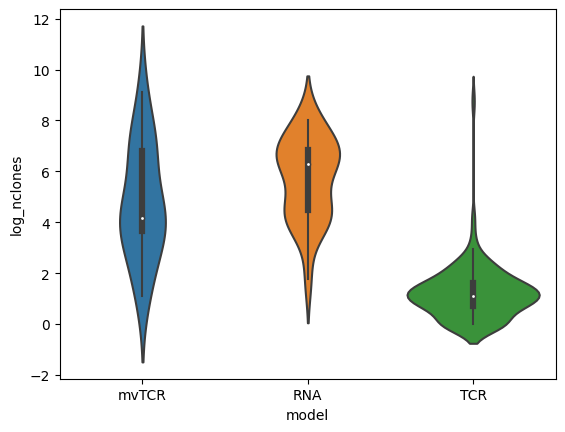

In [36]:
df_nclones = []

for name, latent in [('mvTCR', latent_moe), ('RNA', latent_rna), ('TCR', latent_tcr)]:
    df_tmp = latent.obs.groupby('leiden')['clonotype'].nunique()
    df_tmp = pd.DataFrame(df_tmp).reset_index()
    df_tmp['log_nclones'] = np.log(df_tmp['clonotype']) 
    df_tmp['model'] = name
    df_nclones.append(df_tmp)
df_nclones = pd.concat(df_nclones)
plt.show()
sb.violinplot(data=df_nclones, y='log_nclones', x='model')
latent_moe.uns['clones_per_cluster'] = df_nclones

## Multi-Clone Story

In [37]:
latent_moe[latent_moe.obs['binding_name']=='A0201_GILGFVFTL_Flu-MP_Influenza_binder'].obs['Contribution TCR']<0.5

ACGAGGAGTCAATGTC-1-donor_1    False
ATCCGAAGTACCGTTA-1-donor_1    False
ATGGGAGAGCGTAGTG-1-donor_1    False
CATGGCGTCAACGGGA-1-donor_1    False
CCACTACGTCCCTACT-1-donor_1    False
                              ...  
CGCCAAGGTAGATTAG-6-donor_3    False
CGATTGACAGCTTCGG-7-donor_3     True
CTCGGGACAGTCAGCC-7-donor_3    False
CCGTACTGTTACCAGT-8-donor_3     True
CCGTGGAAGGCTCAGA-7-donor_4    False
Name: Contribution TCR, Length: 7380, dtype: bool

In [38]:
latent_gil = latent_moe[latent_moe.obs['binding_name']=='A0201_GILGFVFTL_Flu-MP_Influenza_binder'].copy()
latent_gil.obs['clonotype'].nunique()

968

In [39]:
np.sum(latent_moe[latent_moe.obs['binding_name']=='A1101_AVFDRKSDAK_EBNA-3B_EBV_binder'].obs['Contribution TCR']<0.5)

1528

In [40]:
latent_moe.obs['binding_name'].value_counts()

A0301_KLGGALQAK_IE-1_CMV_binder            26347
B0801_RAKFKQLL_BZLF1_EBV_binder            16478
A0201_GILGFVFTL_Flu-MP_Influenza_binder     7380
A1101_IVTDFSVIK_EBNA-3B_EBV_binder          5657
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder         3510
A0201_GLCTLVAML_BMLF1_EBV_binder            1244
A0301_RLRAEAQVK_EMNA-3A_EBV_binder           380
A0201_ELAGIGILTV_MART-1_Cancer_binder        241
Name: binding_name, dtype: int64

In [41]:
sc.write(adata=latent_moe, filename=f'../results/fig1_moe_None_full.h5ad')
sc.write(adata=latent_rna, filename=f'../results/fig1_rna_None_full.h5ad')
sc.write(adata=latent_tcr, filename=f'../results/fig1_tcr_None_full.h5ad')